In [2]:
! mkdir -p metadata
! cd metadata && wget https://storage.googleapis.com/kaggle-forum-message-attachments/477653/11444/coords-fixed.csv

--2019-03-07 22:04:04--  https://storage.googleapis.com/kaggle-forum-message-attachments/477653/11444/coords-fixed.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.24.144, 2404:6800:4004:80d::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.24.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1190878 (1.1M) [text/csv]
Saving to: ‘coords-fixed.csv’

coords-fixed.csv    100%[===================>]   1.13M  --.-KB/s    in 0.08s   

2019-03-07 22:04:04 (13.9 MB/s) - ‘coords-fixed.csv’ saved [1190878/1190878]



In [5]:
from dlcliche.notebook import *
from whale_plus_utils import *
from config import DATA_PATH
PATH = Path(DATA_PATH)

def get_bbox():
    bbdf = df_load_excel_like('metadata/coords-fixed.csv', preserve_dtype=False)
    bbdf = bbdf.set_index('filename').sort_index()
    coords = bbdf.coords.str.replace('[', '').str.replace(']', '').str.replace(',', ' ')
    coords = np.array([[int(a) for a in coord.split()] for coord in coords])
    assert np.all([len(coord) == 4 for coord in coords])
    bbdf['x0'] = coords[:, 1]
    bbdf['y0'] = coords[:, 0]
    bbdf['x1'] = coords[:, 3]
    bbdf['y1'] = coords[:, 2]
    bbdf = bbdf[bbdf.columns[1:]]
    return bbdf

bbdf = get_bbox()
print(len(bbdf))
bbdf.head()

33321


,x0,y0,x1,y1
filename,,,,
0000e88ab.jpg,189,160,887,433
0001f9222.jpg,4,74,752,251
00028a005.jpg,76,103,978,383
00029d126.jpg,33,33,1021,461
00050a15a.jpg,26,163,1024,372


In [7]:
# Configuration - train-448-AC-CR
AUTO_CONTRAST = True
SZ            = 448
KEEP_ASPECT_RATIO = False
INFLATE_RATE  = 1.1
OUTPUT_TO     = Path('images')
CROP          = True
ORG_TRAIN     = 'train'
ORG_TEST      = 'test'

In [8]:
# Auto make folders...
_AC = '-AC' if AUTO_CONTRAST else ''
_SZ = f'-{SZ}' if SZ else ''
_AR = '-AR' if KEEP_ASPECT_RATIO else ''
_CR = '-CR' if CROP else ''
TRAIN_OUT = OUTPUT_TO/f'{ORG_TRAIN}{_SZ}{_AC}{_AR}{_CR}'
TEST_OUT = OUTPUT_TO/f'{ORG_TEST}{_SZ}{_AC}{_AR}{_CR}'

ensure_folder(TRAIN_OUT)
ensure_folder(TEST_OUT)
print(TRAIN_OUT, TEST_OUT)

images/train-448-AC-CR images/test-448-AC-CR


In [9]:
# List files
bfiles = sorted(list(map(str, bbdf.index)))
files = sorted(list((PATH/ORG_TRAIN).iterdir()) + list((PATH/ORG_TEST).iterdir()))
len(files)

33321

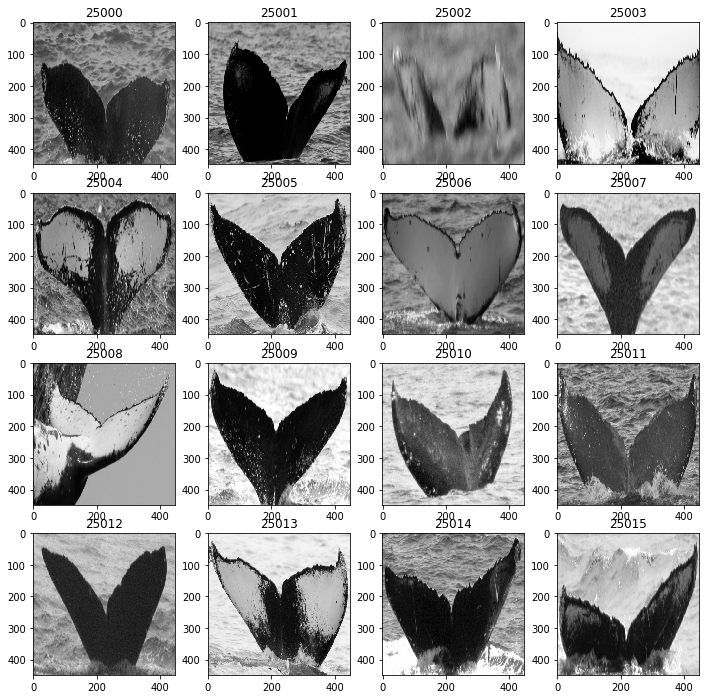

In [10]:
from PIL import ImageOps, Image
from dlcliche.image import *

def aspect_ratio_keep_in_square(org_size, crop_size):
    ow, oh = org_size
    cw, ch = crop_size
    org_ratio = ow / oh
    crop_ratio = cw / ch
    if org_ratio > crop_ratio:
        cw = ch
    else:
        ch = cw
    return cw, ch

def get_coods_fixed(filename):
    x0, y0, x1, y1 = bbdf.loc[filename].values
    if x1 <= x0 or y1 <= y0:
        print(f'Warninig {x0} {y0} {x1} {y1} was fixed for {filename}.')
    x0, x1 = (x0, x1) if x0 < x1 else (x1, x0)
    y0, y1 = (y0, y1) if y0 < y1 else (y1, y0)
    return x0, y0, x1, y1

def get_cropped_image(path, keep_aspect_ratio=False, auto_contrast=False):
    filename = str(path.name)
    image = Image.open(path)
    iw, ih = image.size
    x0, y0, x1, y1 = get_coods_fixed(filename)
    w, h = x1 - x0, y1 - y0
    w, h = INFLATE_RATE*w, INFLATE_RATE*h
    if keep_aspect_ratio:
        w, h = aspect_ratio_keep_in_square(image.size, (w, h))
    wp2, hp2 = w/2, h/2
    cx, cy = (x1 + x0) / 2, (y1 + y0) / 2
    x0, y0, x1, y1 = cx - wp2, cy - hp2, cx + wp2, cy + hp2
    x0, y0 = int(np.clip(x0, 0, iw)), int(np.clip(y0, 0, ih))
    x1, y1 = int(np.clip(x1, 0, iw)), int(np.clip(y1, 0, ih))
    if CROP:
        image = image.crop([x0, y0, x1, y1])
    if auto_contrast:
        image = ImageOps.autocontrast(image)
    if SZ:
        image = image.resize((SZ,SZ), resample=Image.BICUBIC)
    return image.convert('LA').convert('RGB')

def resize_img(path, index, ax=plt, view=False):
    img = get_cropped_image(path, 
                            keep_aspect_ratio=KEEP_ASPECT_RATIO,
                            auto_contrast=AUTO_CONTRAST)
    if view:
        ax.set_title(str(index))
        ax.imshow(img)
    img.save((OUTPUT_TO/f'{path.parent.name}{_SZ}{_AC}{_AR}{_CR}'/path.name))

for i, ax in enumerate(subplot_matrix(columns=4, rows=4)):
    i = 25000 + i
    resize_img(files[i], i, ax=ax, view=True)

In [11]:
%%time
from fastai.basics import *
parallel(resize_img, files)

Warninig 166 406 230 398 was fixed for 6a72d84ca.jpg.
CPU times: user 13.4 s, sys: 1.92 s, total: 15.3 s
Wall time: 1min 22s
